# **Dự Đoán Giá Nhà từ Dữ Liệu Bất Động Sản ở Hà Nội (Tuần 1)**

Trong bài tập này, chúng ta sẽ xây dựng một mô hình dự đoán giá nhà sử dụng các thông số có sẵn và thức hiện lan truyền xuôi.

**Dữ Liệu**:

Chúng ta sẽ sử dụng tập dữ liệu về dự đoán giá nhà được lấy từ Kaggle (https://www.kaggle.com/datasets/ladcva/vietnam-housing-dataset-hanoi/data). Tập dữ liệu này chứa thông tin về các giao dịch bất động sản ở Hà Nội, bao gồm các thuộc tính liên quan như địa chỉ, quận, huyện, diện tích, số phòng ngủ,... và giá bán. Mục tiêu của chúng ta là xây dựng một mô hình để dự đoán giá của các căn nhà dựa trên các thuộc tính này.

**Phương Pháp**:

Chúng ta sẽ tiến hành các bước sau:
* Tải thông số mô hình mạng thần kinh nhân tạo
* Xây dựng mô hình mạng thần kinh nhân tạo dựa trên thông số đã tải
* Thực hiện lan truyền xuôi

# Tải các dữ liệu đầu vào

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Vì bài tập tuần 1 chỉ tập trung vào lan truyền xuôi, chúng ta sẽ tải những dữ liệu và thông số đã được xử lý. Đầu tiên chúng ta sẽ tải các biến đã được xử lý vào notebook (X_train, y_train, X_test, y_test). Trong đó:
- Train (Dữ liệu huấn luyện): Dùng để dạy mô hình học từ dữ liệu, với X_train là biến đầu vào và y_train là nhãn đầu ra.
- Test (Dữ liệu kiểm tra): Dùng để đánh giá hiệu suất của mô hình sau khi huấn luyện, với X_test là biến đầu vào và y_test là nhãn đầu ra.

Giải thích thư viện: **NumPy** (`import numpy as np`):
   - **Mục đích**: NumPy là thư viện nền tảng cho tính toán khoa học trong Python.
   - **Chức năng chính**: Cung cấp các mảng (arrays) và ma trận (matrices) đa chiều hiệu suất cao, cùng với các hàm toán học để thao tác với chúng.

In [ ]:
import numpy as np

# Tải tệp .npz
data = np.load('/content/drive/MyDrive/notebook/train_test_split_data.npz')

# Trích xuất các biến
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

# Đóng tệp
data.close()

In [ ]:
# In kích thước các biến
print("X_train shape "+str(X_train.shape))
print("X_test shape "+str(X_test.shape))
print("y_train shape "+str(y_train.shape))
print("y_test shape "+str(y_test.shape))

X_train shape (52551, 6)
X_test shape (22523, 6)
y_train shape (52551,)
y_test shape (22523,)


# Xử lý thông số mô hình

Để dự đoán giá nhà, chúng ta cần phải huấn luyện mô hình mạng thần kinh. Tuy nhiên, bài tập này chỉ giới hạn trong việc lan truyền xuôi (forward propagation), mô hình này đã được huấn luyện sẵn. Việc của chúng ta trong bài tập này là tải các thông số của mô hình được huấn luyện sẵn và chạy lan truyền xuôi trên tập X_test. Ở phần này, chúng ta sẽ:
  * Tải lên trọng số của mô hình
  * Chạy mô hình qua dữ liệu test
  * Viết hàm mất mát

Giải thích thư viện: **TensorFlow/Keras** (`from tensorflow.keras.models import load_model`):
   - **Mục đích**: Thư viện mã nguồn mở cho học sâu và học máy.
   - **Chức năng chính**: `load_model` dùng để tải một mô hình đã được huấn luyện trước đó từ tệp, giúp tái sử dụng mô hình mà không cần huấn luyện lại.

In [ ]:
from tensorflow.keras.models import load_model

path = '/content/drive/MyDrive/notebook/hanoi_model.keras'

model = load_model(path)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │              70 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 164 (660.00 B)

 Trainable params: 81 (324.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 83 (336.00 B)

Dòng code này trích xuất các thông số từ mô hình đã được huấn luyện và lưu trữ chúng trong danh sách parameters. Ta sẽ chia parameters ra thành weights và biases ở phía dưới.

In [ ]:
# Lấy các thông số từ mô hình đã được huấn luyện
parameters = []
for layer in model.layers:
    if hasattr(layer, 'get_weights'):
        weights = layer.get_weights()
        parameters.extend(weights)

Sau đó chúng ta thực hiện việc trích xuất trọng số (weights) và tham số (biases) của mỗi layer từ danh sách parameters, và lưu trữ chúng vào các biến w và b.

In [ ]:
layer = 1

w = []
b = []
output_w = None
output_b = None

for i, layer_weights in enumerate(parameters):
    if i == len(parameters)-2:
        output_w = layer_weights.T
    elif i == len(parameters)-1:
        output_b = layer_weights
    elif (i+1) % 2 != 0:
        w.append(layer_weights.T)
    else:
        b.append(layer_weights)
        layer += 1

w = np.array(w)
b = np.array(b)

In [ ]:
print("w shape: " + str(w.shape))
print("b shape: " + str(b.shape))

w shape: (1, 10, 6)
b shape: (1, 10)


Để thực hiện việc cộng ma trận cho hàm predict ở dưới, chúng ta cần thay đổi hình dạng của mảng b từ (4, 19) thành (4, 19, 1) bằng cách thêm một chiều mới ở cuối mảng.

Lý do cụ thể là trong một số ngôn ngữ lập trình hoặc thư viện như NumPy trong Python, các phép toán ma trận yêu cầu các mảng phải có cùng số chiều hoặc có thể được "broadcast" để có cùng số chiều. Bằng cách thêm một chiều mới, mảng b có thể "broadcast" phù hợp với mảng khác mà có thể có hình dạng (4, 19, n) cho một số giá trị của n. Điều này cho phép thực hiện các phép toán như cộng hoặc nhân theo từng phần tử một cách đúng đắn trên từng phần tử tương ứng trong cả hai mảng.

In [ ]:
# Đổi kích thước b thành (4, 19, 1)
b = np.expand_dims(b, axis=-1)

In [ ]:
print("w shape: " + str(w.shape))
print("b shape: " + str(b.shape))

w shape: (1, 10, 6)
b shape: (1, 10, 1)


In [ ]:
print("output w shape: " + str(output_w.shape))
print("output b shape: " + str(output_b.shape))

output w shape: (1, 10)
output b shape: (1,)


## Bài tập: Hàm ReLU

Hàm này là hàm kích hoạt ReLU (Rectified Linear Activation Function), được định nghĩa bằng công thức:
* ReLU(x) = max(0, x)

Hàm này trả về giá trị của x nếu x lớn hơn hoặc bằng 0, và trả về 0 nếu x nhỏ hơn 0. Điều này làm cho hàm ReLU trở thành một hàm phi tuyến tính, giúp nó hoạt động tốt trong việc giải quyết vấn đề biến mất đạo hàm và tăng cường hiệu suất của mạng nơ-ron.

Gợi ý: sử dụng hàm [numpy.maximum](https://numpy.org/doc/stable/reference/generated/numpy.maximum.html)

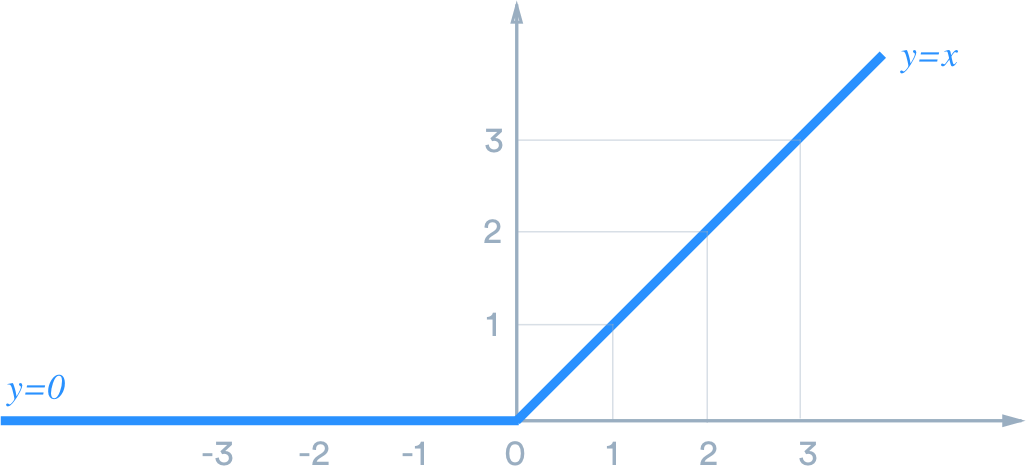

In [ ]:
def relu(x):
    """
    Hàm kích hoạt ReLU (Rectified Linear Unit).

    Tham số:
    x -- một số nguyên hoặc mảng numpy.

    Trả về:
    Một số nguyên hoặc mảng numpy, trong đó mỗi phần tử được áp dụng hàm ReLU.
    """
    ### BEGIN SOLUTION
    return np.maximum(0, x)
    ### END SOLUTION

In [ ]:
# Tests 10 points.

assert relu(5) == 5

### BEGIN HIDDEN TESTS
assert relu(-2) == 0
assert relu(2) == 2
assert relu(0) == 0
assert np.array_equal(relu(np.array([-1, 0, 1, 2])), np.array([0, 0, 1, 2]))
### END HIDDEN TESTS

In [ ]:
# Ví dụ
x = np.array([-1, 0, 1, 2])
print(relu(x))

[0 0 1 2]


## Bài tập: Xây mô hình

Như đã giải thích trong phần xây dựng mô hình sử dụng Keras:
* Input layer: một lớp Dense với 6 neurons tương ứng 6 thuộc tính.
* Hidden layers: Thêm 1 lớp Dense với mỗi lớp có 10 neurons và hàm kích hoạt là 'relu'.
* Output layer: Thêm một lớp Dense với 1 neurons (vì đây là bài toán dự đoán giá) mà không có activation function (hàm kích hoạt) (vì đây là bài toán linear regression (dự đoán giá trị liên tục)).

Phép biến đổi tuyến tính: Sử dụng ma trận trọng số (w) và đầu vào (Z), cộng với vector độ lệch (b). Cụ thể, công thức này có thể được viết dưới dạng:

\begin{equation*}
\mathbf{Z}_{hidden} = \mathbf{w}^{[l]} \mathbf{Z}_{hidden}^T + \mathbf{b}
\end{equation*}

Để hiểu hơn về nhân tích vô hướng, chúng ta có thể sử dụng ví dụ ở dưới với ma trận A*B=C. Trong đó ma trận A có kích thước (nxn), B có kích thước (nxm) và C với kích thước (nxm). Trong hình phía dưới, chúng ta sẽ cho 3 ma trận (A, B, C) có kích thuớc (3x3) để dễ minh họa.

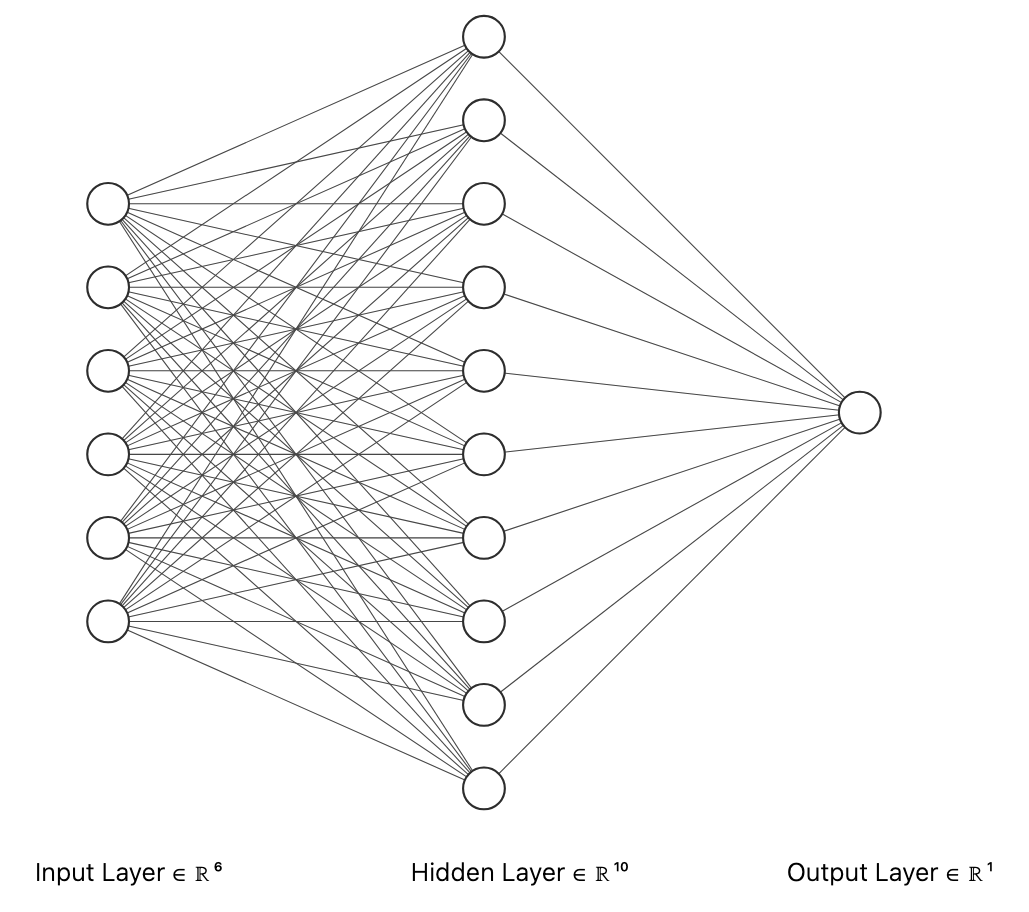

Để giải thích kĩ hơn, hidden layer được tính như sau:

1. Ma trận đầu vào có kích thước (6,22523), nghĩa là có 6 features và 22523 mẫu dữ liệu.
\begin{equation*}
X = Z_0 = \begin{bmatrix}
    z_{1-1} & z_{1-2} & \dots & z_{1-22523}\\
    \vdots & \ddots & & \ddots\\
    z_{6-1} & z_{6-2} & \dots & z_{6-22523}\\
    \end{bmatrix}
\quad \text{shape: } (6, 22523)
\\
\end{equation*}

2. Ma trận trọng số giữa input layer và hidden layer có kích thước (10,6), tức là có 10 neurons trong hidden layer và mỗi neuron liên kết với 6 features từ input layer.
 \begin{equation*}
 W_1 = \begin{bmatrix}
    w_{1-1} & w_{1-2} & \dots & w_{1-6}\\
    \vdots & \ddots & & \ddots\\
    w_{10-1} & w_{10-2} & \dots & w_{10-6}\\
    \end{bmatrix}
\quad \text{shape: } (10, 6)
\\
\end{equation*}

3. Vector bias của hidden layer có kích thước (10,1), tức là mỗi neuron trong hidden layer có một bias.

\begin{equation*}
b_1 = \begin{bmatrix}
    b_{1}\\
    \vdots\\
    b_{10}\\
    \end{bmatrix}
\quad \text{shape: } (10, 1)
\\
\end{equation*}

4. Ma trận output của hidden layer sau khi nhân với trọng số và cộng bias.
\begin{equation*}
Z_1 = Z_0 \cdot W_1 + b_1
\quad \text{shape: } (10, 22523)
\end{equation*}

Tương tự như vậy, output layer được tính như sau:

\begin{equation*}
Z_1 = \begin{bmatrix}
    z_{1-1} & z_{1-2} & \dots & z_{1-22523}\\
    \vdots & \ddots & & \ddots\\
    z_{10-1} & z_{10-2} & \dots & z_{10-22523}\\
    \end{bmatrix}
\quad \text{shape: } (10, 22523)
\\
\end{equation*}
\begin{equation*}
W_2 = \begin{bmatrix}
    w_{1} & w_{2} & \dots & w_{10}\\
    \end{bmatrix}
\quad \text{shape: } (1, 10)
\\
\end{equation*}
\begin{equation*}
b_2 = \begin{bmatrix}
    b_{1}\\
    \end{bmatrix}
\quad \text{shape: } (1,)
\\
\end{equation*}

6. Ma trận output cuối cùng của mạng sau khi nhân với trọng số và cộng bias.
\begin{equation*}
Z_2 = Z_1 \cdot W_2 + b_2
\quad \text{shape: } (1, 22523)
\end{equation*}

Trong ví dụ trên, Z*W sử dụng tích vô hướng, ta có ví dụ về tích vô hướng ở hình dưới (AB=C), trong đó:

\begin{equation*}
c_{1} = a_{1}b_{1} + a_{2}b_{4} + a_{3}b_{7}
\end{equation*}

tương tự với các giá trị c khác.

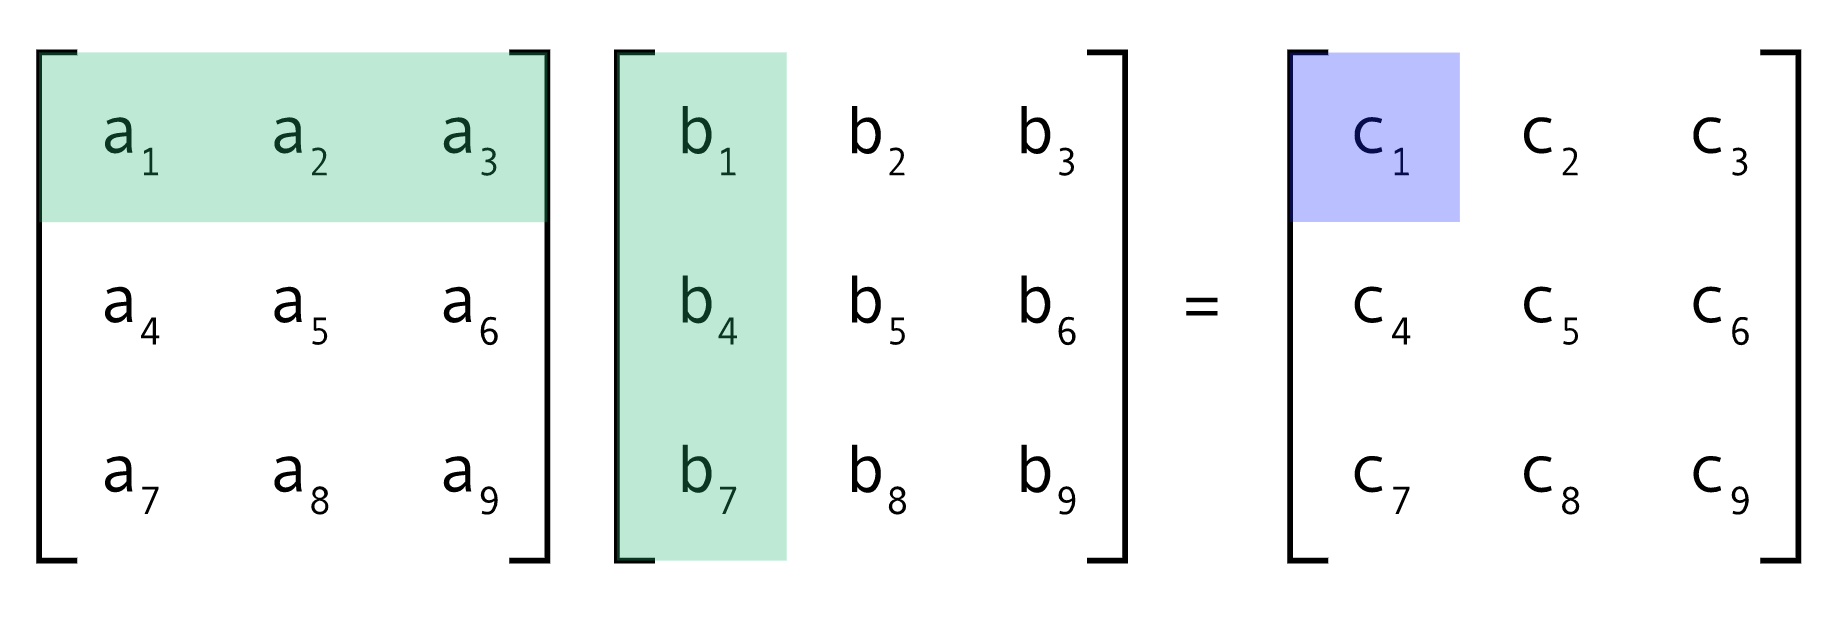

Nguồn ảnh: [Charchithowitzer](https://charchithowitzer.medium.com/matrix-multiplication-why-is-it-a-big-deal-cc8ef7490008).

Gợi ý:
* Dùng hàm for để loop qua các layer của mô hình.
* Sử dụng [numpy.dot](https://numpy.org/doc/stable/reference/generated/numpy.dot.html) để thực hiện nhân tích vô hướng
* Sử dụng relu ở cuối các hidden layers.

In [ ]:
def predict(w, b, output_w, output_b, X):
    '''
    Dự đoán đầu ra bằng cách sử dụng các tham số đã học cho một mô hình hồi quy tuyến tính với nhiều lớp.

    Tham số:
    w -- danh sách trọng số của các lớp ẩn, mỗi phần tử là một mảng numpy có hình dạng (kích_thước_của_lớp_ẩn, kích_thước_của_input)
    b -- danh sách độ lệch của các lớp ẩn, mỗi phần tử là một mảng numpy có hình dạng (kích_thước_của_lớp_ẩn, 1)
    output_w -- trọng số của lớp đầu ra, một mảng numpy có hình dạng (kích_thước_của_output, kích_thước_của_lớp_ẩn)
    output_b -- độ lệch của lớp đầu ra, một mảng numpy có hình dạng (kích_thước_của_output, 1)
    X -- dữ liệu đầu vào có hình dạng (số_lượng_attribut, số_lượng_examples)

    Trả về:
    Z_output -- một mảng numpy (vector) chứa các dự đoán cho dữ liệu đầu vào X
    '''

    # Truyền qua các lớp ẩn
    Z_hidden = X  # Khởi tạo với dữ liệu đầu vào

    ### BEGIN SOLUTION
    for l in range(len(w)):
        # Tính toán các kích hoạt của lớp ẩn
        Z_hidden = np.dot(w[l], Z_hidden) + b[l]

        # Áp dụng hàm kích hoạt (ví dụ, ReLU)
        Z_hidden = relu(Z_hidden)  # Hàm kích hoạt ReLU

    # Tính toán các kích hoạt của lớp đầu ra
    Z_output = np.dot(output_w, Z_hidden) + output_b
    ### END SOLUTION

    return Z_output

In [ ]:
# Tests 10 points.

# Test 1: 1 input
X1 = np.array([[-0.73684943, -0.51745793, -1.6646029,   1.4674629,   0.04104468, -0.36828932]])
Z_output1 = predict(w, b, output_w, output_b, X1.T)
expected_output1 = np.array([[50]])
assert np.allclose(np.round(Z_output1), expected_output1, atol=1e-6), f"Test 1 sai: Đáp án {expected_output1}, kết quả thực tế {Z_output1}"

### BEGIN HIDDEN TESTS
# Test 2: Multiple examples input
X2 = np.array([[1, 2, 3, 4, 5, 6], [6, 5, 4, 3, 2, 1]])
Z_output2 = predict(w, b, output_w, output_b, X2.T)
expected_output2 = np.array([[362, 173]])
assert np.allclose(np.round(Z_output2), expected_output2, atol=1e-6), f"Test 2 failed: Expected {expected_output2}, but got {np.round(Z_output2)}"

# Test 3: Input with all zeros
X3 = np.zeros((2, 6))
Z_output3 = predict(w, b, output_w, output_b, X3.T)
expected_output3 = np.array([[47, 47]])
assert np.allclose(np.round(Z_output3), expected_output3, atol=1e-6), f"Test 3 failed: Expected {expected_output3}, but got {np.round(Z_output3)}"

# Test 4: Input with negative values
X4 = np.array([[-1, -2, -3, -4, -5, -6], [-6, -5, -4, -3, -2, -1]])
Z_output4 = predict(w, b, output_w, output_b, X4.T)
expected_output4 = np.array([[0, 1]])
assert np.allclose(np.round(Z_output4), expected_output4, atol=1e-6), f"Test 4 failed: Expected {expected_output4}, but got {np.round(Z_output4)}"
### END HIDDEN TESTS

Sau khi hoàn chỉnh mô hình, ta sẽ cho X_test và trọng số vào để dự đoán.

In [ ]:
predictions = predict(w, b, output_w, output_b, X_test.T)

# Đánh giá kết quả

Sử dụng thư viện matplotlib để vẽ biểu đồ so sánh giữa giá trị thực tế trên tập kiểm tra (y_test) và giá trị được dự đoán bởi mô hình (predictions).

Các chấm (predictions) càng gần đường thẳng (giá trị thực y_test) chứng tỏ mô hình dự đoán càng tốt.

Giải thích thư viện: **Matplotlib** (`import matplotlib.pyplot as plt`):
   - **Mục đích**: Thư viện tiêu chuẩn để vẽ biểu đồ và đồ thị trong Python.
   - **Chức năng**: Cung cấp các công cụ để tạo các biểu đồ đường, biểu đồ cột, biểu đồ tán xạ, và nhiều loại biểu đồ khác. `%matplotlib inline` là một câu lệnh đặc biệt trong Jupyter Notebook để hiển thị biểu đồ ngay trong notebook.

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

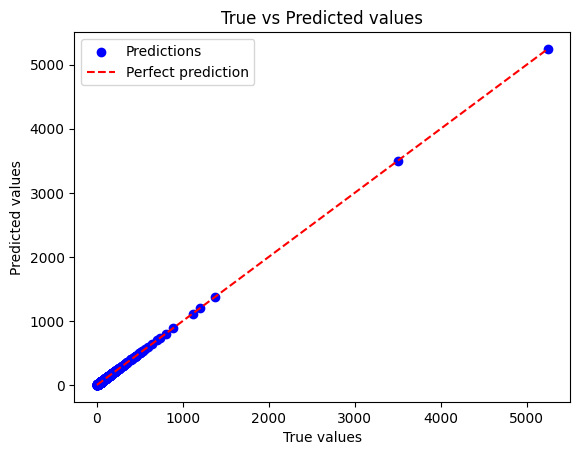

In [ ]:
# Vẽ biểu đồ
plt.scatter(y_test, predictions, color='blue', label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect prediction')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('True vs Predicted values')
plt.legend()
plt.show()

#Thử với data trong dataset

Đầu tiên, ta sẽ lấy 1 data trong X_test và in ra thông tin trong đó.

In [ ]:
x_demo = X_test[0].reshape((1, -1))
print(x_demo)

[[-0.98443252 -1.26801036  0.43489474  1.4674629  -0.1497691  -1.42432425]]


Để chuyển đổi data về giá trị ban đầu, ta cần:

*   Trung bình bằng 0 và độ lệch chuẩn bằng 1
*   LabelEncoder từ thư viện sklearn.preprocessing để chuyển đổi các giá trị trong các cột 'Đường', 'Quận', 'Huyện', và 'Loại hình nhà ở' từ dạng số sang dạng chuỗi.

Đầu tiên, ta cần tải các encoder đã được tạo sẵn (tuần 3) sử dụng thư viện joblib.

In [ ]:
import joblib

# Tải các encoders
quan_label_encoder = joblib.load('/content/drive/MyDrive/notebook/quan_label_encoder.pkl')
huyen_label_encoder = joblib.load('/content/drive/MyDrive/notebook/huyen_label_encoder.pkl')
loai_hinh_nha_o_label_encoder = joblib.load('/content/drive/MyDrive/notebook/loai_hinh_nha_o_label_encoder.pkl')
duong_label_encoder = joblib.load('/content/drive/MyDrive/notebook/duong_label_encoder.pkl')

# Tải giá trị trung bình và độ lệch chuẩn
mean = joblib.load('/content/drive/MyDrive/notebook/mean.pkl')
std = joblib.load('/content/drive/MyDrive/notebook/std.pkl')

In [ ]:
# Convert x_demo back to original data
x_demo_original = x_demo * std + mean

# Convert categorical features back to original values
quan = quan_label_encoder.inverse_transform([int(x_demo_original[0][0])])[0]
huyen = huyen_label_encoder.inverse_transform([int(x_demo_original[0][1])])[0]
loai_hinh_nha_o = loai_hinh_nha_o_label_encoder.inverse_transform([int(x_demo_original[0][2])])[0]
duong = duong_label_encoder.inverse_transform([int(x_demo_original[0][5])])[0]
so_phong_ngu = int(x_demo_original[0][3])
dien_tich = int(x_demo_original[0][4])

print({'đường': duong, 'quận': quan, 'huyện': huyen, 'loại hình nhà ở': loai_hinh_nha_o, 'số phòng ngủ': so_phong_ngu, 'diện tích': dien_tich})

{'đường': 'cầu giấy', 'quận': 'Quận Cầu Giấy', 'huyện': 'Phường Dịch Vọng', 'loại hình nhà ở': 'Nhà ngõ, hẻm', 'số phòng ngủ': 6, 'diện tích': 38}


Cuối cùng, xem giá nhà dự đoán ở vị trí X_train[0].

In [ ]:
demo_prediction = predict(w, b, output_w, output_b, x_demo.T)
print(f"Giá nhà dự đoán {demo_prediction}")
print(f"Giá nhà thực tế {y_test[0]}")

Giá nhà dự đoán [[38.00065946]]
Giá nhà thực tế 38


# Thử với data của bạn

Đầu tiên, ta cần nhập vào input và mã hóa các thông tin của đường, quận, huyện, loại hình nhà ở. Ta sẽ sử dụng LabelEncoder để chuyển hóa dữ liệu từ số sang chữ (giải thích kĩ ở tuần 3).

Lưu ý:
* Chỉ nhập tên đường, không bắt đầu bằng "đường" hoặc "phố".
* Đối với data không được train, cell này sẽ xảy ra lỗi.

In [ ]:
duong = 'minh khai'
quan = 'Quận Hai Bà Trưng'
huyen = 'Phường Minh Khai'
loai = 'Nhà mặt phố, mặt tiền'
so_phong = 6
dien_tich = 50

# Chuyển đổi cột 'Địa chỉ'
duong = duong_label_encoder.transform([duong])[0]

# Chuyển đổi cột 'Quận'
quan = quan_label_encoder.transform([quan])[0]

# Chuyển đổi cột 'Huyện'
huyen = huyen_label_encoder.transform([huyen])[0]

# Chuyển đổi cột 'Loại hình nhà ở'
loai = loai_hinh_nha_o_label_encoder.transform([loai])[0]

Sau đó, chúng ta chuẩn hóa x cho chúng có trung bình bằng 0 và độ lệch chuẩn bằng 1. (giải thích kĩ ở tuần 3)

In [ ]:
input = [[quan, huyen, loai, so_phong, dien_tich, duong]]
input = np.array(input)
input = (input-mean)/std
print(input)

[[-0.73684943 -0.51745793 -1.6646029   1.4674629   0.04104468 -0.36828932]]


Cuối cùng, xem giá nhà dự đoán của bạn.

In [ ]:
input_prediction = predict(w, b, output_w, output_b, input.T)
print(input_prediction)

[[49.96507766]]
